# Importación de librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Carga de datos

In [2]:
headers = pd.read_csv('../Data/handles-data.csv')
tweets = pd.read_csv('../Data/tweets-data.csv')
pd.options.display.float_format = '{:.2f}'.format

/home/julianmelero/twitter-ai/twai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Target Clasificación

In [3]:
tweets["nretweets"].isnull().sum()

0

In [4]:
tweets["nretweets"].quantile([0.7,0.8,0.9,0.95,1])

0.70       49.00
0.80      104.00
0.90      311.00
0.95      871.00
1.00   541964.00
Name: nretweets, dtype: float64

Aquellos tweets que están por debajo o igual al percentil 80 serán como no populares.
Establezco todos los tweets como poco populares de entrada, así si exiten nulos estos estarán como "no populares". 

In [5]:
# unpopular:0 popular:1
tweets["label"] = pd.qcut(tweets["nretweets"], [0.80,0.85,1], labels=["0","1"] )

In [6]:
tweets["label"][tweets["label"].isnull()] = "0"

In [7]:
tweets["label"].head(8)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    0
Name: label, dtype: category
Categories (2, object): ['0' < '1']

Observamos que la distribución de los tweets populares es un 14.98% del total, sin quitar todavía los datos de entramiento y test. Esto podría parecer poco, pero lo que estamos buscando son aquellos tweets sumamente populares. Esto es debido a que el dataset ofrecido contiene muchos tweets populares como ya vimos en el análisis anterior.

In [8]:
tweets.groupby('label').size()

label
0    34501
1     6080
dtype: int64

In [9]:
round((tweets[tweets["label"]=="0"]["label"].count() / tweets["label"].count()) * 100,2)

85.02

In [10]:
round((tweets[tweets["label"]=="1"]["label"].count() / tweets["label"].count()) * 100,2)

14.98

No tenemos datos nulos en el label

In [11]:
print(tweets[tweets["label"].isnull()]["label"].count())

0


<AxesSubplot:xlabel='label', ylabel='Count'>

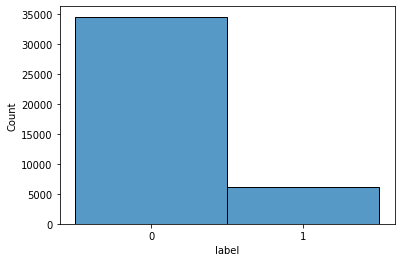

In [12]:
sns.histplot(data=tweets,x=tweets["label"])

# Variables Relevantes

### Unir los datos

In [13]:
union = pd.merge(headers, tweets, left_on='username', right_on='username' )
union.describe()
union.to_csv("../Data/union_categorical.csv",sep=";", index=False)

In [14]:
union = pd.read_csv("../Data/union_categorical.csv", sep=";")

/home/julianmelero/twitter-ai/twai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Followers

Considerando el análisis inicial de los datos, el número de seguidores (followers), sigue siendo una variable a tener en cuenta para conocer la popularidad de un tweet.
En este caso, en vez de tomarlo como numérico, lo pasaremos a categórico.

En primer lugar observamos la dispersión de los datos:

In [15]:
headers["followers"].quantile([0.4,0.5,0.65,0.7,0.8,0.85,0.9,0.95,1])

0.40     3705270.00
0.50     4462139.00
0.65     6345799.50
0.70     7216548.00
0.80    10608102.00
0.85    13958885.50
0.90    18754004.00
0.95    36826698.00
1.00   129909278.00
Name: followers, dtype: float64

Considerando que el primer salto importante se da entre el percentil 60 y 80, empezaremos a dividir los datos por categorías, en este caso en dos. Siendo por ejemplo, número de seguidores "no relevante" y "relevante".
Tomo esta decisión ya que en el dataset todos tienen una cantidad de followers exagerada, y creo que es mejor dividirlo de esta forma.

In [16]:
union["followers_categorical"] = pd.qcut(union["followers"], [0.60,0.80,1], labels=["0", "1"])

In [17]:
union["followers_categorical"]

0          1
1          1
2          1
3          1
4          1
        ... 
40862    NaN
40863    NaN
40864    NaN
40865    NaN
40866    NaN
Name: followers_categorical, Length: 40867, dtype: category
Categories (2, object): ['0' < '1']

In [18]:
union["followers_categorical"][union["followers_categorical"].isnull()] = "0"

In [19]:
union[union["followers_categorical"].isnull()]["followers_categorical"].count()

0

<AxesSubplot:xlabel='followers_categorical', ylabel='Count'>

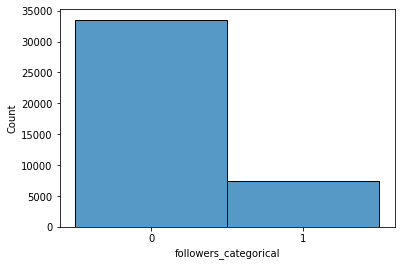

In [20]:
sns.histplot(data=union,x=union["followers_categorical"])

## Tiene URLS

In [21]:
union["have_urls"] = union["urls"] != "[]"

In [22]:
union.loc[union["have_urls"] == True, 'have_urls'] = "1"

In [23]:
union.loc[union["have_urls"] == False, 'have_urls'] = "0"

In [24]:
union["have_urls"]

0        0
1        0
2        0
3        1
4        0
        ..
40862    0
40863    0
40864    0
40865    0
40866    0
Name: have_urls, Length: 40867, dtype: object

In [25]:
(union[union["have_urls"]== "0"]["have_urls"].count() / union["have_urls"].count()) * 100

46.13012944429491

In [26]:
(union[union["have_urls"]== "1"]["have_urls"].count() / union["have_urls"].count()) * 100

53.86987055570509

In [27]:
union["have_urls"].value_counts(sort=True)

1    22015
0    18852
Name: have_urls, dtype: int64

<AxesSubplot:xlabel='have_urls', ylabel='Count'>

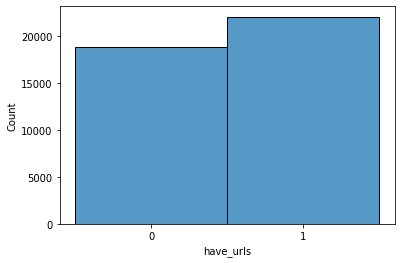

In [28]:
sns.histplot(data=union,x=union["have_urls"])

## Tiene Hashtags

In [29]:
union["hashtags"].head(15)

0                                         []
1     ['shoesdaytuesday', 'afterskewlslide']
2                                         []
3                                         []
4                                         []
5                       ['climateemergency']
6                                         []
7                                         []
8                                         []
9                                         []
10                                        []
11                                        []
12                                        []
13                                        []
14                               ['freeguy']
Name: hashtags, dtype: object

In [30]:
union["have_hashtags"] = union["hashtags"] != "[]"

In [31]:
union.loc[union["have_hashtags"] == True, 'have_hashtags'] = "1"
union.loc[union["have_hashtags"] == False, 'have_hashtags'] = "0"

In [32]:
union["have_hashtags"].value_counts(sort=True)

0    35528
1     5339
Name: have_hashtags, dtype: int64

<AxesSubplot:xlabel='have_hashtags', ylabel='Count'>

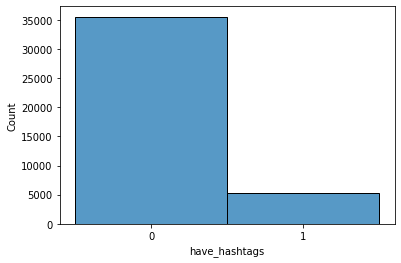

In [33]:
sns.histplot(data=union,x=union["have_hashtags"])

## Fecha de unión

In [34]:
union["join_date"] = pd.to_datetime(union["join_date"])
union["join_date"] = union["join_date"].dt.year

In [35]:
union["join_date"]

0        2011
1        2009
2        2009
3        2009
4        2009
         ... 
40862    2011
40863    2011
40864    2011
40865    2011
40866    2011
Name: join_date, Length: 40867, dtype: int64

# Variables Modelo

In [36]:
variables = union[["followers_categorical", "have_urls", "have_hashtags", "join_date"]]

In [37]:
variables.head(10)

,followers_categorical,have_urls,have_hashtags,join_date
0,1,0,0,2011
1,1,0,1,2009
2,1,0,0,2009
3,1,1,0,2009
4,1,0,0,2009
5,1,0,1,2009
6,1,0,0,2008
7,1,0,0,2009
8,1,0,0,2009
9,1,0,0,2009


In [38]:
variables.groupby(["join_date","followers_categorical","have_urls"]).count()

have_hashtags
join_date followers_categorical have_urls               
2006      0                     0                     74
                                1                      7
          1                     0                      0
                                1                      0
2007      0                     0                   1763
                                1                   6248
          1                     0                    683
                                1                   4434
2008      0                     0                   2795
                                1                   5362
          1                     0                    288
                                1                    390
2009      0                     0                   4708
                                1                   3599
          1                     0                    902
                                1                    170
2010      0                     0                   2601
                                1                    381
          1                     0                    137
                                1                     14
2011      0                     0                   2731
                                1                   1037
          1                     0                     94
                                1                     21
2012      0                     0                    933
                                1                     97
          1                     0                    186
                                1                     25
2013      0                     0                    378
                                1                     66
          1                     0                      4
                                1                      0
2014      0                     0                    302
                                1                    110
          1                     0                      0
                                1                      0
2015      0                     0                     79
                                1                      3
          1                     0                      0
                                1                      0
2016      0                     0                     14
                                1                     17
          1                     0                      0
                                1                      0
2017      0                     0                     69
                                1                      7
          1                     0                      0
                                1                      0
2018      0                     0                      9
                                1                      0
          1                     0                      0
                                1                      0
2020      0                     0                     68
                                1                     20
          1                     0                      0
                                1                      0
2021      0                     0                     34
                                1                      7
          1                     0                      0
                                1                      0

In [39]:
target = union[["label"]]

In [40]:
target.shape

(40867, 1)

In [41]:
variables.shape

(40867, 4)

In [42]:
target.head(8)

,label
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,0


# Separación de datos train/test

In [43]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(variables, target, test_size=0.3, random_state=25 )

In [44]:
y_train.head(8)

,label
39447,0
1286,0
5726,0
4633,0
22650,0
12019,0
22132,0
973,1


In [45]:
X_train.astype(int)

,followers_categorical,have_urls,have_hashtags,join_date
39447,0,1,1,2007
1286,0,1,0,2008
5726,0,0,1,2009
4633,1,0,0,2009
22650,1,1,0,2007
...,...,...,...,...
35702,1,1,0,2007
26767,0,1,0,2008
6618,0,0,1,2010
24894,0,1,0,2007


# Entrenamiento

In [46]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

2022-03-31 19:36:02.444006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 19:36:02.444058: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [47]:
tf.random.set_seed = 25

In [48]:
model = Sequential()
model.add(Dense(4, activation="relu", input_dim=4))
model.add(Dense(1, activation="sigmoid"))

2022-03-31 19:36:05.436244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-31 19:36:05.436369: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-31 19:36:05.436400: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-MRGEAIRC): /proc/driver/nvidia/version does not exist
2022-03-31 19:36:05.437842: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
model.compile(optimizer="adam" ,loss='binary_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(X_train.astype(int),y_train, epochs=10, validation_data=[X_test.astype(int),y_test])

Epoch 1/10
894/894 [==============================] - 4s 4ms/step - loss: 11.8331 - val_loss: 0.5231
Epoch 2/10
894/894 [==============================] - 3s 4ms/step - loss: 0.4398 - val_loss: 0.4038
Epoch 3/10
894/894 [==============================] - 5s 5ms/step - loss: 0.4309 - val_loss: 0.4039
Epoch 4/10
894/894 [==============================] - 3s 4ms/step - loss: 0.4220 - val_loss: 0.3837
Epoch 5/10
894/894 [==============================] - 3s 4ms/step - loss: 0.4249 - val_loss: 0.4034
Epoch 6/10
894/894 [==============================] - 4s 5ms/step - loss: 0.4179 - val_loss: 0.3821
Epoch 7/10
894/894 [==============================] - 4s 4ms/step - loss: 0.4167 - val_loss: 0.3825
Epoch 8/10
894/894 [==============================] - 4s 4ms/step - loss: 0.4278 - val_loss: 0.4132
Epoch 9/10
894/894 [==============================] - 3s 4ms/step - loss: 0.4147 - val_loss: 0.3879
Epoch 10/10
894/894 [==============================] - 3s 4ms/step - loss: 0.4233 - val_loss: 0.390

In [51]:
history.history

{'loss': [11.833134651184082,
  0.4397921860218048,
  0.4309004247188568,
  0.42201149463653564,
  0.42491036653518677,
  0.4179333448410034,
  0.4167035222053528,
  0.42778724431991577,
  0.41474804282188416,
  0.4232553243637085],
 'val_loss': [0.5230534672737122,
  0.40383726358413696,
  0.40390002727508545,
  0.3837295174598694,
  0.40340685844421387,
  0.3821205496788025,
  0.3825068175792694,
  0.4131649136543274,
  0.3879331946372986,
  0.3908902704715729]}

In [52]:
# followers_categorical	have_urls	have_hashtags	join_date
res =model.predict([[1,0,0,2009]])

In [53]:
print(res[0])

[0.44725785]


In [54]:
predicho = model.predict(X_test.astype(int))

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [88]:
model_regression = LogisticRegression() 
model_regression.fit(X_train, y_train)

/home/julianmelero/twitter-ai/twai/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [89]:
predicciones_regression = model_regression.predict(X_test)

/home/julianmelero/twitter-ai/twai/lib/python3.8/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


In [91]:
df = pd.DataFrame(data=predicciones_regression, columns=["Prediction"])

In [92]:
df[df["Prediction"]>0.5].count()

Prediction    694
dtype: int64

In [69]:
from sklearn.metrics import confusion_matrix

In [93]:
confusion_matrix(y_test, predicciones_regression)

array([[10063,   319],
       [ 1504,   375]])

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

/home/julianmelero/twitter-ai/twai/lib/python3.8/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


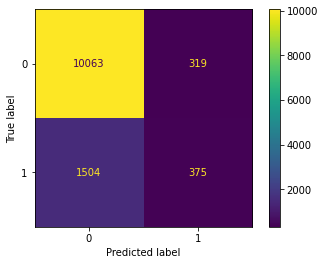

In [105]:
ConfusionMatrixDisplay.from_estimator(model_regression, X_test, y_test, values_format=".0f")

## Random Forest

In [84]:
rf_clf  = RandomForestClassifier(random_state=42)

In [85]:
rf_clf.fit(X_train,y_train)

/tmp/ipykernel_814/1435717670.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train,y_train)


RandomForestClassifier(random_state=42)

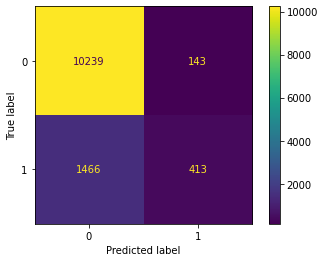

In [104]:
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, values_format=".0f")

In [74]:
X_train.shape

(28606, 4)